# Evaluating Classification: ROC/AUC

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.utils import resample
from sklearn.datasets import load_breast_cancer, load_iris, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report, RocCurveDisplay

# Objectives

- Calculate and interpret probability estimates
- Adjust the threshold of a logistic regression model
- Visualize, calculate and interpret the AUC-ROC metric

# Motivation

Now that we've learned how to evaluate a classification model's predictions, let's dig deeper to see how else we might evaluate our models and how we can use that information to improve them.

# Scenario: Identifying Heart Disease

Let's use [this UCI dataset](https://archive.ics.uci.edu/ml/datasets/Heart+Disease) about predicting heart disease.

In [2]:
hd_data = pd.read_csv('data/heart.csv')
hd_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [3]:
hd_data['target'].value_counts()

1    165
0    138
Name: target, dtype: int64

In [4]:
hd_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
# Separate data into feature and target DataFrames
X = hd_data.drop('target', axis=1)
y = hd_data['target']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Scale the data for modeling
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

# Train a logistic regresssion model with the train data
hd_model = LogisticRegression(random_state=42)
hd_model.fit(X_train_sc, y_train)

LogisticRegression(random_state=42)

## Predicting Labels

Let's look at some predictions from our example.

In [6]:
y_pred = hd_model.predict(X_test_sc)

In [7]:
y_pred

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1])

In [9]:
y_test.values

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 1])

When we run the `.predict()` method, `sklearn` gives us the predicted values for each transaction in our test set: 0 if predicting "no heart disease", 1 if predicting "heart disease"

## Probability Estimates

If you remember how the logistic regression model works, though, it doesn't actually generate predicted values of 0 or 1. It creates an S-shaped curve to approximate the data, estimating the _probability_ that they belong to the target class. This probability takes a value _between_ 0 and 1.

![](https://www.graphpad.com/guides/prism/latest/curve-fitting/images/hmfile_hash_38a8acae.png)

Source: [GraphPad](https://www.graphpad.com/guides/prism/latest/curve-fitting/reg_simple_logistic_and_linear_difference.htm)

We can get these estimated probabilities using the `.predict_proba()` method. Each element gives two probabilities: the estimate probability of being in the 0 class (not heart disease) and the 1 class (heart disease)

In [10]:
y_prob = hd_model.predict_proba(X_test_sc)
y_prob[:5]

array([[0.99583439, 0.00416561],
       [0.2234686 , 0.7765314 ],
       [0.91939062, 0.08060938],
       [0.99402865, 0.00597135],
       [0.97047813, 0.02952187]])

In [11]:
y_pred[:5]

array([0, 1, 0, 0, 0])

## Thresholds

How did we get those 0 and 1 label predictions, when the model only calculates probabilities between 0 and 1? 

The default behavior is simply to take the larger of these values as the "real" prediction. Since $0.996 > 0.004$, we'd understand the model to be predicting this point to belong to class "0" (or the negative class). An equivalent way of understanding the default behavior is that we either:

- Round the predicted numbers up to 1 if they are at least as large as 0.5
- Round them down to 0 if they are less than 0.5

Since the probabilities must sum to 1, there will never be any problem with this algorithm. We refer to this value of 0.5 as the **threshold**.

### But Are We Stuck w/0.5 Threshold?

But we don't have to do things this way. Suppose we're building a model that predicts the presence of cancer from X-ray scans. And suppose we get a pair of probabilities for some particular scan that look like this:

- pred_neg: 0.52, pred_pos: 0.48

Because false negatives (cancers not flagged) are *much* more costly than false positives (non-cancers flagged as cancers), we may well want to **adjust our threshold**. We might want to have our model predict "positive" if the corresponding probability is, say, as low as 0.4, or maybe even as low as 0.1. (Speaking for myself, if there was even a 10% chance that I had cancer, I think I'd probably want to know about it.) 

## True & False Positive Rates

Adjusting the threshold can increase or decrease performance on different evaluation metrics. When doing this, data scientist often look at changes in two metrics: **True Positive Rate (TPR)** and **False Positive Rate (FPR)**. Let's define and calculate these. 

To do this, we'll first need to get the values from the confusion matrix.

In [12]:
hd_model.score(X_train_sc, y_train)

0.8810572687224669

In [13]:
hd_model.score(X_test_sc, y_test)

0.75

In [14]:
cm = confusion_matrix(y_test, hd_model.predict(X_test_sc))

In [15]:
cm

array([[24, 11],
       [ 8, 33]])

In [16]:
tp, tn, fp, fn = cm[1][1], cm[0][0], cm[0][1], cm[1][0]

### True Positive Rate

True Positive Rate (TPR) is the same as recall, measuring how many of the positive cases we correctly classified as positive.

**True Positive Rate (TPR)** = **Recall** = $\frac{TP}{TP + FN}$

How many of the patients with heart disease did my model identify?

In [17]:
tpr = tp / (tp + fn)
print(tpr)

0.8048780487804879


### False Positive Rate

False Positive Rate (FPR) measures how many of the negative casses we incorrectly classified as positive.

**False Positive Rate (TPR)** = $\frac{FP}{FP + TN}$

How many of the patients without heart disease did my model flag as having heart disease?

In [18]:
fpr = fp / (fp + tn)
print(fpr)

0.3142857142857143


## Adjusting the threshold

The true- and false-positive rates will change if we make adjustments to the threshold. In fact, in the present case that was the whole point of making the adjustment: We want to minimize our false negatives.

This is how the plot of these rates takes shape.

Let's build a function that will take in our data, together with a threshold setting, and return the corresponding true- and false-positive rates.

# The Receiver Operating Characteristic (ROC) Curve

The Receiver Operating Characteristic (ROC) curve plots the true-positive rate vs. the false-positive rate. Let's define these now:

In [19]:
def classify_rates(y_test, y_probs, model, thresh):
    y_hat = []
    for val in y_probs:                 # Each element in y_hat_probs is an array.
        if val[1] < thresh:             # We'll set our own threshold for classifying
            y_hat.append(0)             # a test point as positive! The lower my threshold,
        else:                           # the fewer predicted positives I'll have. For the
            y_hat.append(1)             # cancer example, I'd want to set a *high* threshold.
    cm = confusion_matrix(y_test, y_hat)
    tp, tn, fp, fn = cm[1][1], cm[0][0], cm[0][1], cm[1][0]
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return tpr, fpr, f'tpr:{round(tpr, 3)}, fpr:{round(fpr, 3)}'

True- and false-positive rates for various thresholds:

In [21]:
for x in np.linspace(0, 1, 11):
    print(f'Rates at threshold = {round(x, 2)}: '\
          + classify_rates(y_test, y_prob, hd_model, x)[2])

Rates at threshold = 0.0: tpr:1.0, fpr:1.0
Rates at threshold = 0.1: tpr:0.951, fpr:0.429
Rates at threshold = 0.2: tpr:0.902, fpr:0.4
Rates at threshold = 0.3: tpr:0.878, fpr:0.314
Rates at threshold = 0.4: tpr:0.878, fpr:0.314
Rates at threshold = 0.5: tpr:0.805, fpr:0.314
Rates at threshold = 0.6: tpr:0.805, fpr:0.286
Rates at threshold = 0.7: tpr:0.732, fpr:0.286
Rates at threshold = 0.8: tpr:0.537, fpr:0.114
Rates at threshold = 0.9: tpr:0.463, fpr:0.029
Rates at threshold = 1.0: tpr:0.0, fpr:0.0


In [20]:
np.linspace(0, 1, 11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

As my threshold goes up, I'll have fewer positive predictions, which means I'll have both fewer true positives and fewer false positives.

> **NOTE**
>
> - I can artificially increase my true-positive rate to 1 by setting my threshold to 0, but at that point my false-positive rate is also 1! I'll have no true negatives and no false negatives. This will arise naturally if my training data has **very few (actual) negatives**. 
> - I can artificially reduce my false-positive rate to 0 by setting my threshold to 1, but at  that point my true-positive rate is also 0! I'll have no true positives and no false positives. This will arise naturally if my training data has **very few (actual) positives**. 

## Plotting the Curve

Let's plot our own ROC curve. We'll create an array of different thresholds and use our `classify_rates()` function to get the true- and false-positive rates for each threshold.

One way of choosing a threshold **independently of business concerns** is to select the point on the curve that is furthest from (1, 0), the "worse-case" point where our true-positive rate is 0 and our false-positive rate is 1. So let's find that point as well:

With a threshold of 0.07: 
	You'll have a True Positive Rate of 0.976 
	and a False Positive Rate of 0.457


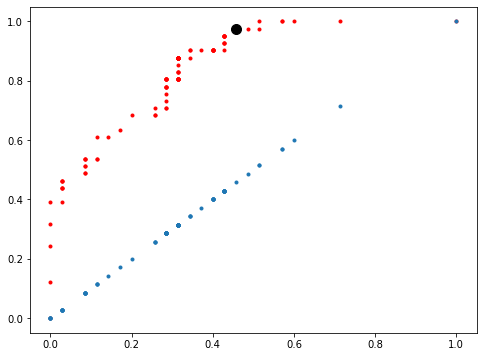

In [22]:
tprs = []
fprs = []
diffs = []
for x in np.linspace(0, 1, 101):
    fprs.append(classify_rates(y_test, y_prob, hd_model, x)[1])
    tprs.append(classify_rates(y_test, y_prob, hd_model, x)[0])
    diffs.append(np.sqrt(tprs[-1]**2 + (1-fprs[-1])**2))
    
max_dist = diffs.index(np.max(diffs))
print(f"""With a threshold of {(max_dist - 1) / 100}: \n"""
      f"""\tYou\'ll have a True Positive Rate of {round(tprs[max_dist], 3)} \n"""
      f"""\tand a False Positive Rate of {round(fprs[max_dist], 3)}""")

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fprs[:max_dist], tprs[:max_dist], 'r.')
ax.plot(fprs[max_dist], tprs[max_dist], 'ko', ms=10)
ax.plot(fprs[max_dist + 1:], tprs[max_dist + 1:], 'r.')
ax.plot(fprs, fprs, '.');

Let's compare our curve with scikit-learn's:

In [25]:
y_hat_hd = y_prob
y_hat_hd

array([[0.99583439, 0.00416561],
       [0.2234686 , 0.7765314 ],
       [0.91939062, 0.08060938],
       [0.99402865, 0.00597135],
       [0.97047813, 0.02952187],
       [0.99658357, 0.00341643],
       [0.99074693, 0.00925307],
       [0.30275283, 0.69724717],
       [0.99739018, 0.00260982],
       [0.00792471, 0.99207529],
       [0.71409486, 0.28590514],
       [0.93292466, 0.06707534],
       [0.18390061, 0.81609939],
       [0.81713066, 0.18286934],
       [0.7337857 , 0.2662143 ],
       [0.04665008, 0.95334992],
       [0.00661731, 0.99338269],
       [0.99248657, 0.00751343],
       [0.50742352, 0.49257648],
       [0.21194814, 0.78805186],
       [0.01477391, 0.98522609],
       [0.98185534, 0.01814466],
       [0.23346936, 0.76653064],
       [0.01687133, 0.98312867],
       [0.01274579, 0.98725421],
       [0.20218495, 0.79781505],
       [0.99651613, 0.00348387],
       [0.0148034 , 0.9851966 ],
       [0.08467156, 0.91532844],
       [0.00590972, 0.99409028],
       [0.

In [27]:
y_hat_hd = y_prob[:, 1]
y_hat_hd

array([0.00416561, 0.7765314 , 0.08060938, 0.00597135, 0.02952187,
       0.00341643, 0.00925307, 0.69724717, 0.00260982, 0.99207529,
       0.28590514, 0.06707534, 0.81609939, 0.18286934, 0.2662143 ,
       0.95334992, 0.99338269, 0.00751343, 0.49257648, 0.78805186,
       0.98522609, 0.01814466, 0.76653064, 0.98312867, 0.98725421,
       0.79781505, 0.00348387, 0.9851966 , 0.91532844, 0.99409028,
       0.96460629, 0.86104856, 0.79704685, 0.79899187, 0.04591461,
       0.45628628, 0.0887099 , 0.25532985, 0.75680156, 0.05818162,
       0.9649659 , 0.04562099, 0.17855578, 0.00210274, 0.76485113,
       0.88556113, 0.2934572 , 0.73637076, 0.75528847, 0.94425146,
       0.96586718, 0.77717419, 0.88992217, 0.70320688, 0.99306432,
       0.98664928, 0.76416585, 0.0123491 , 0.72140869, 0.01826694,
       0.46929446, 0.99463107, 0.97935593, 0.94372066, 0.5891358 ,
       0.97553787, 0.64710039, 0.0790008 , 0.14414374, 0.01668925,
       0.88352892, 0.97471045, 0.00233839, 0.68248119, 0.00526

In [28]:
roc_curve(y_test, y_hat_hd)

(array([0.        , 0.        , 0.        , 0.02857143, 0.02857143,
        0.08571429, 0.08571429, 0.11428571, 0.11428571, 0.17142857,
        0.17142857, 0.2       , 0.2       , 0.25714286, 0.25714286,
        0.28571429, 0.28571429, 0.31428571, 0.31428571, 0.34285714,
        0.34285714, 0.42857143, 0.42857143, 0.51428571, 0.51428571,
        1.        ]),
 array([0.        , 0.02439024, 0.3902439 , 0.3902439 , 0.46341463,
        0.46341463, 0.53658537, 0.53658537, 0.6097561 , 0.6097561 ,
        0.65853659, 0.65853659, 0.68292683, 0.68292683, 0.70731707,
        0.70731707, 0.80487805, 0.80487805, 0.87804878, 0.87804878,
        0.90243902, 0.90243902, 0.97560976, 0.97560976, 1.        ,
        1.        ]),
 array([1.99463107, 0.99463107, 0.96460629, 0.95334992, 0.91532844,
        0.88556113, 0.84869964, 0.81609939, 0.79704685, 0.77717419,
        0.76653064, 0.76485113, 0.76416585, 0.75528847, 0.73637076,
        0.72140869, 0.64710039, 0.5891358 , 0.45628628, 0.2934572 ,
    

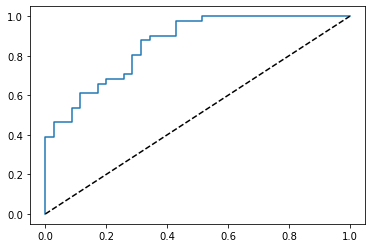

In [29]:
# Extract the probability predictions for the "1" class (heart disease)
y_hat_hd = y_prob[:, 1]

# Get the FPR and TPR data
fpr, tpr, thresholds = roc_curve(y_test, y_hat_hd)

# Plot the FPR and TPR data
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot((0,1), (0,1), 'k--');

### `RocCurveDisplay()`

You can also use the `RocCurveDislay` with just your fitted model and test data.

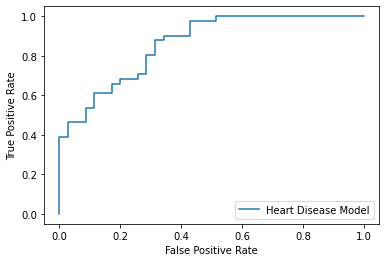

In [32]:
roc_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name='Heart Disease Model')
roc_disp.plot();

## Area Under the Curve (AUC)

The ROC curve will be a plot of tpr (on the y-axis) vs. fpr (on the x-axis). There will always be a point at (0, 0) and another at (1, 1). The question is what happens in the middle. Since we want our y-values to be as high as possible for any particular x-value, a natural metric is to calculate the **area under the curve**. The larger the area, the better the classifier. The maximum possible area is the area of the whole box between 0 and 1 on both axes, so that's a **maximum area of 1**.

What's the minimum? Well that depends on the ratios of (actual) positive and negatives in my data, in much the way that a baseline accuracy score does.

> Remember: If my test data comprises 90% positives and only 10% negatives, then a simple classifier that always predicts "positive" will be 90% accurate! And so that would be the baseline level for a classifier on that data.

If we have equal numbers of positives and negatives, then we can set an **absolute minimum area of 0.5**. That's the "curve" we'd get by plotting a straight diagonal line from (0, 0) to (1, 1).

Why? The area under the curve really represents the test's ability to **discriminate** positives from negatives. Suppose I randomly took several pairs of points, one positive and one negative, and checked my test's predictions. The area under the curve represents a threshold-independent measure of how often my test would get the two predictions correct.

### AUC Calculation with `sklearn`

Scikit-Learn's `roc_auc_score()` function will compute the area under the curve for us:

In [33]:
y_prob

array([[0.99583439, 0.00416561],
       [0.2234686 , 0.7765314 ],
       [0.91939062, 0.08060938],
       [0.99402865, 0.00597135],
       [0.97047813, 0.02952187],
       [0.99658357, 0.00341643],
       [0.99074693, 0.00925307],
       [0.30275283, 0.69724717],
       [0.99739018, 0.00260982],
       [0.00792471, 0.99207529],
       [0.71409486, 0.28590514],
       [0.93292466, 0.06707534],
       [0.18390061, 0.81609939],
       [0.81713066, 0.18286934],
       [0.7337857 , 0.2662143 ],
       [0.04665008, 0.95334992],
       [0.00661731, 0.99338269],
       [0.99248657, 0.00751343],
       [0.50742352, 0.49257648],
       [0.21194814, 0.78805186],
       [0.01477391, 0.98522609],
       [0.98185534, 0.01814466],
       [0.23346936, 0.76653064],
       [0.01687133, 0.98312867],
       [0.01274579, 0.98725421],
       [0.20218495, 0.79781505],
       [0.99651613, 0.00348387],
       [0.0148034 , 0.9851966 ],
       [0.08467156, 0.91532844],
       [0.00590972, 0.99409028],
       [0.

In [34]:
# Extract the probabilitiy predictions for the "1" class (heart disease)
y_hat_hd = y_prob[:, 1]

roc_auc_score(y_test, y_hat_hd)

0.8606271777003485

In [36]:
accuracy_score(y_test, y_pred)

0.75

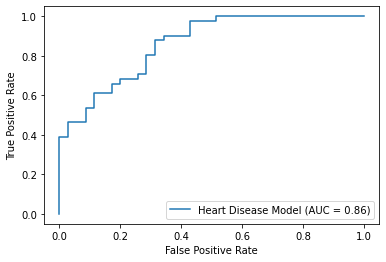

In [35]:
roc_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name='Heart Disease Model', roc_auc=roc_auc_score(y_test, y_hat_hd))
roc_disp.plot();

## Sidebar: Visualizing Threshold Changes

This [ROC Applet](https://web.archive.org/web/20210210014824/http://www.navan.name/roc/) helps  visualize how a change in the threshold corresponds to moving along the ROC curve

# Scenario: Breast Cancer Prediction

Let's evaluate a model using Scikit-Learn's breast cancer dataset:

In [37]:
# Load the data
preds, target = load_breast_cancer(return_X_y=True)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(preds, target,
                                                   random_state=42)

# Scale the data
bc_scaler = StandardScaler()
bc_scaler.fit(X_train)
X_train_sc = bc_scaler.transform(X_train)
X_test_sc = bc_scaler.transform(X_test)

# Run the model
bc_model = LogisticRegression(solver='lbfgs', max_iter=100,
                           random_state=42)
bc_model.fit(X_train_sc, y_train)

LogisticRegression(random_state=42)

## Task

For this example, draw the ROC curve and calculate the AUC-ROC metric. Based on the results, do you think your model would be useful for identifying patients with breast cancer?

In [39]:
# Your work here
# Lets look at Confusion Matrix first
cm = confusion_matrix(y_test, bc_model.predict(X_test_sc))
cm

array([[53,  1],
       [ 2, 87]])

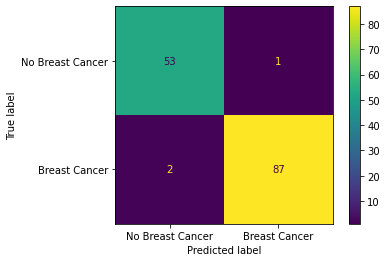

In [42]:
ConfusionMatrixDisplay(cm, display_labels=['No Breast Cancer', 'Breast Cancer']).plot();

In [48]:
bc_model.predict_proba(X_train_sc)[:,1]

array([9.99968681e-01, 2.86372729e-03, 9.99269608e-01, 3.72508743e-06,
       1.56225670e-06, 3.12407064e-01, 9.99821120e-01, 5.70673632e-02,
       9.99859132e-01, 9.99990745e-01, 9.75398786e-01, 9.99178294e-01,
       6.18453263e-13, 1.13427902e-04, 9.99964009e-01, 9.90780240e-01,
       9.99982238e-01, 9.99999939e-01, 9.99567184e-01, 9.99815711e-01,
       9.97570884e-01, 7.33803170e-02, 9.99036228e-01, 9.99105247e-01,
       6.83299028e-01, 9.99979683e-01, 1.74319982e-02, 9.81099838e-01,
       9.98772191e-01, 9.99150500e-01, 9.26665623e-01, 9.97609453e-01,
       9.66511224e-01, 1.20477289e-01, 9.63918963e-01, 9.97954196e-01,
       9.81301874e-01, 9.16866033e-01, 9.26851529e-01, 9.99556534e-01,
       1.11925633e-02, 1.92824524e-04, 4.27388391e-02, 4.92050840e-01,
       9.28192270e-01, 6.31052182e-03, 9.99001091e-01, 2.32228401e-07,
       9.90446033e-01, 9.98741496e-01, 9.99981203e-01, 9.99405499e-01,
       3.23840169e-02, 7.72854562e-01, 9.99907632e-01, 1.28940353e-06,
      

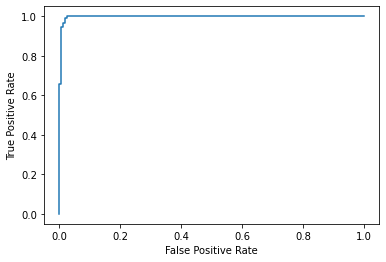

In [50]:
#Train ROC-AUC
fpr, tpr, thresh = roc_curve(y_train, bc_model.predict_proba(X_train_sc)[:,1])
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

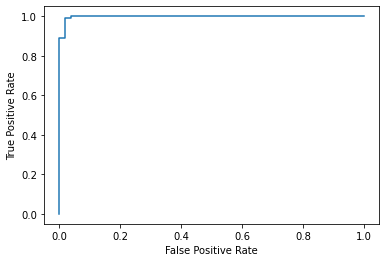

In [51]:
#Test ROC-AUC
fpr, tpr, thresh = roc_curve(y_test, bc_model.predict_proba(X_test_sc)[:,1])
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [52]:
bc_model.score(X_train_sc, y_train)

0.9859154929577465

In [53]:
bc_model.score(X_test_sc, y_test)

0.9790209790209791

In [55]:
np.bincount(y_test)

array([54, 89])

In [56]:
np.bincount(y_train)

array([158, 268])

In [57]:
bc_model.predict_proba(X_test_sc)[0]

array([0.12423828, 0.87576172])

In [58]:
roc_auc_score(y_test, bc_model.predict_proba(X_test_sc)[:, 1])

0.9977111943404079

In [59]:
recall_score(y_train, bc_model.predict(X_train_sc))

0.9925373134328358

In [60]:
recall_score(y_test, bc_model.predict(X_test_sc))

0.9775280898876404

# Level Up: Oversampling
## Coming soon in another lecture

What do you do if your model doesn't perform well due to class imbalance? One of the most effective strategies is to **oversample the minority class**. That is, I give myself more data points than I really have. I could achieve this either by [bootstrapping](https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html) or by generating some data that is fake but close to actual data. The latter is the idea behind [SMOTE](https://imbalanced-learn.org/stable/over_sampling.html).

In [ ]:
# Another less intensive method that might help
log_class_weights = LogisticRegression(class_weight='balanced')